##### Reading DF

In [1]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
sc = SparkContext("local[*]")
spark = SparkSession.builder.getOrCreate()
import pandas as pd  


23/02/25 13:06:54 WARN Utils: Your hostname, ubuntu-hadoop resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
23/02/25 13:06:54 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/02/25 13:06:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/02/25 13:06:58 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
# spark = SparkSession.builder.getOrCreate()
from  pyspark.sql.functions import split
import pandas as pd 
from pyspark.ml.feature import StringIndexer # to convert class labels to numeric
from pyspark.sql.functions import col
from pyspark.sql import functions as F
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, CountVectorizer
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, when
from pyspark.ml.feature import ChiSqSelector

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

## reading the data 

In [3]:
file_path_testing ="../data/test.txt"
file_path_training= "../data/train.txt"
file_path_val= "../data/val.txt"


def readFile(file_path):
    df_row = spark.read.csv(file_path)
    # print("original")
    # print(df_row.show(4,False))
    df= df_row.withColumn("text", split(df_row['_c0'], ';').getItem(0))\
            .withColumn('emotion', split(df_row['_c0'], ';').getItem(1))
    df1= df.select("text", "emotion")
    return df1

df_training = readFile(file_path= file_path_training)
df_testing = readFile(file_path= file_path_training)
df_val = readFile(file_path= file_path_val)
print(df_val.show(4,False))

+----------------------------------------------------------------------+-------+
|text                                                                  |emotion|
+----------------------------------------------------------------------+-------+
|im feeling quite sad and sorry for myself but ill snap out of it soon |sadness|
|i feel like i am still looking at a blank canvas blank pieces of paper|sadness|
|i feel like a faithful servant                                        |love   |
|i am just feeling cranky and blue                                     |anger  |
+----------------------------------------------------------------------+-------+
only showing top 4 rows

None


## data prep

In [5]:

print("training size ",df_training.toPandas().shape , "data points") 
print("testing size ",df_testing.toPandas().shape, "data points")
print("validation size ",df_val.toPandas().shape, "data points") 

training size  (16000, 2) data points
testing size  (16000, 2) data points
validation size  (2000, 2) data points


we see that we have unbalance data we have a lot of joy and sadness label and very little surprise and fear

In [6]:
print("training", df_training.select("emotion").distinct().show())
print("training class count", df_training.groupBy("emotion").count().show())

+--------+
| emotion|
+--------+
|     joy|
|    love|
|   anger|
|    fear|
|surprise|
| sadness|
+--------+

training None
+--------+-----+
| emotion|count|
+--------+-----+
|     joy| 5362|
|    love| 1304|
|   anger| 2159|
|    fear| 1937|
|surprise|  572|
| sadness| 4666|
+--------+-----+

training class count None


# convert labels to the numbers 

In [7]:

# Convert sentiment to numbers  joy =0 love =1 
#converting class labels
string_indexer = StringIndexer(inputCol="emotion",outputCol="class")

# fit the StringIndexer to the DataFrame and transform the DataFrame to add the 'fruits_numeric' column
df_class = string_indexer.fit(df_training).transform(df_training)\
.withColumn('class', col('class').cast("integer"))
df_class.show(5)

+--------------------+-------+-----+
|                text|emotion|class|
+--------------------+-------+-----+
|i didnt feel humi...|sadness|    1|
|i can go from fee...|sadness|    1|
|im grabbing a min...|  anger|    2|
|i am ever feeling...|   love|    4|
|i am feeling grouchy|  anger|    2|
+--------------------+-------+-----+
only showing top 5 rows



In [8]:
# fit the StringIndexer to the DataFrame and transform the DataFrame to add the 'class_numeric' column
df_class = string_indexer.fit(df_training).transform(df_training).withColumn('class', col('class').cast("integer"))
print("training class count", df_class.groupBy("emotion","class").count()
.show(truncate=False))


+--------+-----+-----+
|emotion |class|count|
+--------+-----+-----+
|sadness |1    |4666 |
|love    |4    |1304 |
|surprise|5    |572  |
|joy     |0    |5362 |
|fear    |3    |1937 |
|anger   |2    |2159 |
+--------+-----+-----+

training class count None


In [9]:
df_training.show(5)

+--------------------+-------+
|                text|emotion|
+--------------------+-------+
|i didnt feel humi...|sadness|
|i can go from fee...|sadness|
|im grabbing a min...|  anger|
|i am ever feeling...|   love|
|i am feeling grouchy|  anger|
+--------------------+-------+
only showing top 5 rows



In [10]:
# Apply the UDF to a DataFrame column
df_training = df_training.withColumn("text_c", lemmatize_udf(df_training["text_c"]))

NameError: name 'lemmatize_udf' is not defined

In [ ]:
# fit the StringIndexer to the DataFrame and transform the DataFrame to add the 'class_numeric' column
df_training_class = string_indexer.fit(df_training).transform(df_training).withColumn('class', col('class').cast("integer"))
df_testing_class = string_indexer.fit(df_testing).transform(df_testing).withColumn('class', col('class').cast("integer"))
df_val_class = string_indexer.fit(df_val).transform(df_val).withColumn('class', col('class').cast("integer"))

df_label1 = df_training_class.groupBy("emotion","class").count().select("emotion", "class").show()
df_label2 = df_testing_class.groupBy("emotion","class").count().select("emotion", "class").show()
df_label3 = df_val_class.groupBy("emotion","class").count().select("emotion", "class").show(truncate=False)



+--------+-----+
| emotion|class|
+--------+-----+
| sadness|    1|
|    love|    4|
|surprise|    5|
|     joy|    0|
|    fear|    3|
|   anger|    2|
+--------+-----+

+--------+-----+
| emotion|class|
+--------+-----+
| sadness|    1|
|    love|    4|
|surprise|    5|
|     joy|    0|
|    fear|    3|
|   anger|    2|
+--------+-----+

+--------+-----+
|emotion |class|
+--------+-----+
|sadness |1    |
|love    |4    |
|surprise|5    |
|joy     |0    |
|fear    |3    |
|anger   |2    |
+--------+-----+



In [ ]:
df_val_class.groupBy("emotion","class").count().select("emotion", "class").show(truncate=False)

+--------+-----+
|emotion |class|
+--------+-----+
|sadness |1    |
|love    |4    |
|surprise|5    |
|joy     |0    |
|fear    |3    |
|anger   |2    |
+--------+-----+



1- Text cleaning/preprocessing: This should be the first step as it involves removing any unnecessary or irrelevant information from the text, such as punctuation, numbers, special characters, and stop words. Text normalization techniques like lowercasing and stemming/lemmatization can also be applied during this step.

In [ ]:

# cleaning 
def clean(df):
    # Remove html tags from text
    df = df.withColumn("text_c", F.regexp_replace(F.col("text"), r'<[^>]+>', ""))
    # Remove non-letters and remove punctuation 
    df = df.withColumn("text_c", F.regexp_replace("text_c", r"[^a-zA-Z ]", ""))
    # Remove words 1, 2 char
    df = df.withColumn("text_c", F.regexp_replace("text_c", r"\b\w{1,2}\b", ""))
    return df



first we clean all the documents 

In [ ]:
df_training_clean = clean(df_training_class )
df_testing_clean= clean(df_testing_class )
df_val_clean =clean(df_val_class)

training_size = df_training_clean.count()
training_size

16000

In [ ]:
df_training_clean.show()

+--------------------+--------+-----+--------------------+
|                text| emotion|class|              text_c|
+--------------------+--------+-----+--------------------+
|i didnt feel humi...| sadness|    1| didnt feel humil...|
|i can go from fee...| sadness|    1| can  from feelin...|
|im grabbing a min...|   anger|    2| grabbing  minute...|
|i am ever feeling...|    love|    4|  ever feeling no...|
|i am feeling grouchy|   anger|    2|     feeling grouchy|
|ive been feeling ...| sadness|    1|ive been feeling ...|
|ive been taking o...|surprise|    5|ive been taking  ...|
|i feel as confuse...|    fear|    3| feel  confused a...|
|i have been with ...|     joy|    0| have been with p...|
| i feel romantic too|    love|    4|   feel romantic too|
|i feel like i hav...| sadness|    1| feel like  have ...|
|i do feel that ru...|     joy|    0|  feel that runni...|
|i think it s the ...|   anger|    2| think   the easi...|
|i feel low energy...| sadness|    1| feel low energy ..

In [ ]:
import spacy
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
# Load the spaCy model
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
def lemmatize_text(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    return " ".join(lemmas)

# Define a UDF to apply the lemmatizer to a column
lemmatize_udf = udf(lemmatize_text, StringType())
# Apply the UDF to a DataFrame column
df_training_clean_1 = df_training_clean.withColumn("text_c", lemmatize_udf(df_training_clean["text_c"]))

for training data find out weights and create weight column

In [ ]:
w_joy = df_training_clean.filter('class == 0').count()/ training_size
w_sadness = df_training_clean.filter('class == 1').count()/ training_size
w_anger = df_training_clean.filter('class == 2').count()/ training_size
w_fear = df_training_clean.filter('class == 3').count()/ training_size
w_love = df_training_clean.filter('class == 4').count()/ training_size
w_surprize = df_training_clean.filter('class == 5').count()/ training_size

print(w_joy, w_sadness, w_anger, w_fear, w_love, w_surprize)

0.335125 0.291625 0.1349375 0.1210625 0.0815 0.03575


In [ ]:

df_training_weight = df_training_clean.withColumn("weight", when(F.col("class")==0,w_joy).
                                                  when(F.col("class")==1,w_sadness).
                                                  when(F.col("class")==2,w_anger).
                                                  when(F.col("class")==3,w_fear).
                                                  when(F.col("class")==4,w_love).
                                                  otherwise(w_surprize))

df_training_weight.show(10)

+--------------------+--------+-----+--------------------+---------+
|                text| emotion|class|              text_c|   weight|
+--------------------+--------+-----+--------------------+---------+
|i didnt feel humi...| sadness|    1| didnt feel humil...| 0.291625|
|i can go from fee...| sadness|    1| can  from feelin...| 0.291625|
|im grabbing a min...|   anger|    2| grabbing  minute...|0.1349375|
|i am ever feeling...|    love|    4|  ever feeling no...|   0.0815|
|i am feeling grouchy|   anger|    2|     feeling grouchy|0.1349375|
|ive been feeling ...| sadness|    1|ive been feeling ...| 0.291625|
|ive been taking o...|surprise|    5|ive been taking  ...|  0.03575|
|i feel as confuse...|    fear|    3| feel  confused a...|0.1210625|
|i have been with ...|     joy|    0| have been with p...| 0.335125|
| i feel romantic too|    love|    4|   feel romantic too|   0.0815|
+--------------------+--------+-----+--------------------+---------+
only showing top 10 rows



In [ ]:

# Tokenize the review text
tokenizer = Tokenizer(inputCol="text_c", outputCol="words",)
# Remove stop words
remover = StopWordsRemover(inputCol=tokenizer.getOutputCol(), outputCol="filtered")
# Create a count vectoriser
countVectorizer = CountVectorizer(inputCol=remover.getOutputCol(), outputCol="rawFeatures", vocabSize=1000)
# Calculate the TF-IDF
idf = IDF(inputCol=countVectorizer.getOutputCol(), outputCol="featuresIDF")
# Crate a preprocessing pipeline with  4 stages
pipeline_p = Pipeline(stages=[tokenizer,remover, countVectorizer, idf])

In [ ]:
# Learn the data preprocessing model
data_model  = pipeline_p.fit(df_training_weight)
print(dir(data_model ))

['__abstractmethods__', '__annotations__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_copyValues', '_copy_params', '_defaultParamMap', '_dummy', '_from_java', '_is_protocol', '_paramMap', '_params', '_randomUID', '_resetUid', '_resolveParam', '_set', '_setDefault', '_shouldOwn', '_testOwnParam', '_to_java', '_transform', 'clear', 'copy', 'explainParam', 'explainParams', 'extractParamMap', 'getOrDefault', 'getParam', 'hasDefault', 'hasParam', 'isDefined', 'isSet', 'load', 'params', 'read', 'save', 'set', 'stages', 'transform', 'uid', 'write']


In [ ]:
# Transform
transformed_training= data_model.transform(df_training_weight)
transformed_test= data_model.transform(df_testing_clean)
transformed_val= data_model.transform(df_val_clean)


In [ ]:

# data_model.stages[2].vocabulary[:10]
data_model.stages

# Get the vocabulary of the CountVectorizerModel
vocab = data_model.stages[2].vocabulary[:10]

# Get the IDF values from the IDFModel
idf = data_model.stages[3].idf[:10]
# Create a dictionary to store the word IDF rates
word_idf = {}

for item in range(10):
    word =vocab[item]
    idf_rate = float(idf[item])
    word_idf[word] = round(idf_rate,2)

print(word_idf)


{'': 0.0, 'feel': 0.41, 'feeling': 1.17, 'like': 1.79, 'really': 2.91, 'know': 2.98, 'time': 3.06, 'get': 3.14, 'little': 3.13, 'people': 3.26}


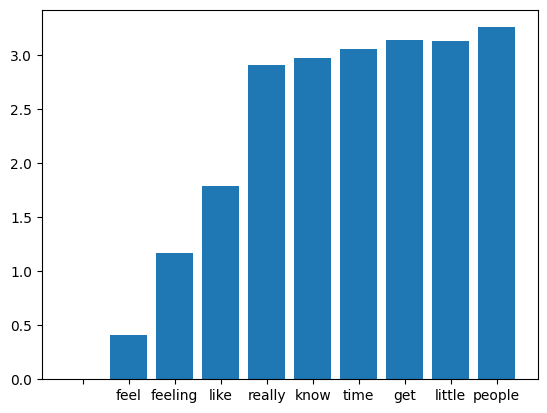

In [ ]:
import matplotlib.pyplot as plt
words= list(word_idf.keys())
values = list(word_idf.values())

plt.bar(range(len(word_idf)), values, tick_label= words)
plt.show()

In [ ]:
transformed_training.show(5)

+--------------------+-------+-----+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
|                text|emotion|class|              text_c|   weight|               words|            filtered|         rawFeatures|         featuresIDF|
+--------------------+-------+-----+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
|i didnt feel humi...|sadness|    1| didnt feel humil...| 0.291625|[, didnt, feel, h...|[, didnt, feel, h...|(1000,[0,1,46,565...|(1000,[0,1,46,565...|
|i can go from fee...|sadness|    1| can  from feelin...| 0.291625|[, can, , from, f...|[, , feeling, , h...|(1000,[0,2,40,51,...|(1000,[0,2,40,51,...|
|im grabbing a min...|  anger|    2| grabbing  minute...|0.1349375|[, grabbing, , mi...|[, grabbing, , mi...|(1000,[0,1,173,32...|(1000,[0,1,173,32...|
|i am ever feeling...|   love|    4|  ever feeling no...|   0.0815|[, , ever, feelin...|

In [ ]:
transformed_test.show(5)

+--------------------+-------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|emotion|class|              text_c|               words|            filtered|         rawFeatures|         featuresIDF|
+--------------------+-------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|i didnt feel humi...|sadness|    1| didnt feel humil...|[, didnt, feel, h...|[, didnt, feel, h...|(1000,[0,1,46,565...|(1000,[0,1,46,565...|
|i can go from fee...|sadness|    1| can  from feelin...|[, can, , from, f...|[, , feeling, , h...|(1000,[0,2,40,51,...|(1000,[0,2,40,51,...|
|im grabbing a min...|  anger|    2| grabbing  minute...|[, grabbing, , mi...|[, grabbing, , mi...|(1000,[0,1,173,32...|(1000,[0,1,173,32...|
|i am ever feeling...|   love|    4|  ever feeling no...|[, , ever, feelin...|[, , ever, feelin...|(1000,[0,2,5,13,6...|(1000,[0,2,5,13,6...|
|i am 

------------------ Adding Feature selection method -----------------

ChiSquare

In [ ]:
from pyspark.ml.feature import NGram
tokenizer = Tokenizer(inputCol="text_c", outputCol="words",)
remover = StopWordsRemover(inputCol=tokenizer.getOutputCol(), outputCol="filtered")
# countVectorizer = CountVectorizer(inputCol=remover.getOutputCol(), outputCol="rawFeatures", vocabSize=1000)
# Define n-gram model
ngram = NGram(n=2, inputCol=remover.getOutputCol(),  outputCol="ngrams")
hashingTF = HashingTF(inputCol="ngrams", outputCol="rawFeatures", numFeatures=10000)
idf = IDF(inputCol=countVectorizer.getOutputCol(), outputCol="featuresIDF")
selector = ChiSqSelector(numTopFeatures=200, featuresCol=idf.getOutputCol(), outputCol="features", labelCol="class")
# Crate a preprocessing pipeline wiht 5 stages
pipeline_2 = Pipeline(stages=[tokenizer,remover,ngram, hashingTF, idf, selector])
# Learn the data preprocessing model
data_model_2 = pipeline_2.fit(df_training_weight)

In [ ]:
vocabulary_v2 = data_model_2.stages[2].vocabulary
selected_indexes = data_model_2.stages[4].selectedFeatures
selected_words = [vocabulary_v2[i] for i in selected_indexes]
print(selected_words)

['sweet', 'stressed', 'strange', 'overwhelmed', 'weird', 'loved', 'angry', 'amazing', 'blessed', 'passionate', 'helpless', 'accepted', 'afraid', 'hated', 'agitated', 'cold', 'towards', 'anxious', 'supporting', 'nervous', 'glad', 'generous', 'sorry', 'loving', 'depressed', 'safe', 'frustrated', 'scared', 'guilty', 'confident', 'beloved', 'miserable', 'exhausted', 'hot', 'missed', 'terrified', 'lovely', 'proud', 'ashamed', 'tortured', 'irritable', 'liked', 'satisfied', 'mad', 'awkward', 'selfish', 'content', 'successful', 'caring', 'lethargic', 'amazed', 'unsure', 'confused', 'bothered', 'unhappy', 'funny', 'inspired', 'popular', 'embarrassed', 'vulnerable', 'shitty', 'annoyed', 'brave', 'talented', 'rich', 'hopeless', 'uncertain', 'greedy', 'uncomfortable', 'shaken', 'punished', 'surprised', 'fucked', 'irritated', 'insecure', 'melancholy', 'devastated', 'impressed', 'aching', 'discouraged', 'offended', 'jealous', 'useful', 'resentful', 'rejected', 'burdened', 'violent', 'dull', 'homesic

In [ ]:
# Transform the data
transformed_training_p2= data_model.transform(df_training_weight)
transformed_test_p2 = data_model.transform(df_testing_clean)
transformed_val_p2 = data_model.transform(df_val_clean)

In [ ]:
data_model.stages

[Tokenizer_3733c725bad1,
 StopWordsRemover_1833830c8b29,
 CountVectorizerModel: uid=CountVectorizer_ea3f4a758a33, vocabularySize=1000,
 IDFModel: uid=IDF_d51a5a276699, numDocs=16000, numFeatures=1000]

In [ ]:
transformed_training_p2.show(5)

+--------------------+-------+-----+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
|                text|emotion|class|              text_c|   weight|               words|            filtered|         rawFeatures|         featuresIDF|
+--------------------+-------+-----+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
|i didnt feel humi...|sadness|    1| didnt feel humil...| 0.291625|[, didnt, feel, h...|[, didnt, feel, h...|(1000,[0,1,46,565...|(1000,[0,1,46,565...|
|i can go from fee...|sadness|    1| can  from feelin...| 0.291625|[, can, , from, f...|[, , feeling, , h...|(1000,[0,2,40,51,...|(1000,[0,2,40,51,...|
|im grabbing a min...|  anger|    2| grabbing  minute...|0.1349375|[, grabbing, , mi...|[, grabbing, , mi...|(1000,[0,1,173,32...|(1000,[0,1,173,32...|
|i am ever feeling...|   love|    4|  ever feeling no...|   0.0815|[, , ever, feelin...|

In [ ]:
transformed_test_p2.show(5)

+--------------------+-------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|emotion|class|              text_c|               words|            filtered|         rawFeatures|         featuresIDF|
+--------------------+-------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|i didnt feel humi...|sadness|    1| didnt feel humil...|[, didnt, feel, h...|[, didnt, feel, h...|(1000,[0,1,46,565...|(1000,[0,1,46,565...|
|i can go from fee...|sadness|    1| can  from feelin...|[, can, , from, f...|[, , feeling, , h...|(1000,[0,2,40,51,...|(1000,[0,2,40,51,...|
|im grabbing a min...|  anger|    2| grabbing  minute...|[, grabbing, , mi...|[, grabbing, , mi...|(1000,[0,1,173,32...|(1000,[0,1,173,32...|
|i am ever feeling...|   love|    4|  ever feeling no...|[, , ever, feelin...|[, , ever, feelin...|(1000,[0,2,5,13,6...|(1000,[0,2,5,13,6...|
|i am 

In [ ]:
df_training_weight.schema

StructType([StructField('text', StringType(), True), StructField('emotion', StringType(), True), StructField('class', IntegerType(), True), StructField('text_c', StringType(), True), StructField('weight', DoubleType(), False)])

feature selection method 3
defining the pipeline stages 

In [ ]:
# from pyspark.ml.classification import RandomForestClassifier

# # Define the preprocessing pipeline
# tokenizer = Tokenizer(inputCol="text_c", outputCol="words")
# remover = StopWordsRemover(inputCol=tokenizer.getOutputCol(), outputCol="filtered")
# countVectorizer = CountVectorizer(inputCol=remover.getOutputCol(), outputCol="rawFeatures", vocabSize=1000)
# idf = IDF(inputCol=countVectorizer.getOutputCol(), outputCol="featuresIDF")



# rfe = RandomForestClassifier( numTrees=10, featuresCol=idf.getOutputCol(), labelCol="class")
# pipeline_3 = Pipeline(stages=[tokenizer, remover, countVectorizer, idf, rfe])
#model3= pipeline_3.fit(df_training_weight)
#model3.stages[-1].featureImportances

# https://www.timlrx.com/blog/feature-selection-using-feature-importance-score-creating-a-pyspark-estimator

In [ ]:
# from pyspark.sql.types import IntegerType
# tokenizer = Tokenizer(inputCol="text_c", outputCol="words",)
# remover = StopWordsRemover(inputCol=tokenizer.getOutputCol(), outputCol="filtered")
# countVectorizer = CountVectorizer(inputCol=remover.getOutputCol(), outputCol="rawFeatures", vocabSize=1000)
# idf = IDF(inputCol=countVectorizer.getOutputCol(), outputCol="featuresIDF")
# lr = LogisticRegression(featuresCol=idf.getOutputCol(), maxIter=100, family="multinomial")
# # lr.setLabelCol("class")
# # Create the pipeline
# pipeline_3 = Pipeline(stages=[tokenizer, remover, countVectorizer, idf, lr])


# # Set up the parameter grid for cross-validation
# param_grid = ParamGridBuilder() \
#              .addGrid(lr.regParam, [0.1, 0.01]) \
#              .addGrid(lr.elasticNetParam, [0.0, 1.0]) \
#              .build()

# # Set up the cross-validator
# cv = CrossValidator(estimator=pipeline_3,
#                     estimatorParamMaps=param_grid,
#                     evaluator=MulticlassClassificationEvaluator(),
#                     numFolds=5)
# # Fit the CrossValidator to the dataset
# df_adjusted = df_training_weight.withColumnRenamed("class", "label")
# cvModel = cv.fit(df_adjusted)

# # # Get the best model from the cross-validation
# # best_model = cvModel.bestModel


In [ ]:
# best_model = cvModel.bestModel
# # best_model.transform(df_testing_clean)

# # Transform the data
# transformed_training_p3= best_model.transform(df_training_weight)
# transformed_test_p3 = best_model.transform(df_testing_clean)
# transformed_val_p3 = best_model.transform(df_val_clean)

In [ ]:
# best_model.stages

[Tokenizer_cabfba633998,
 StopWordsRemover_42f33022cf22,
 CountVectorizerModel: uid=CountVectorizer_c7cf636ed0b9, vocabularySize=1000,
 IDFModel: uid=IDF_018d0d95398d, numDocs=16000, numFeatures=1000,
 LogisticRegressionModel: uid=LogisticRegression_4fc31110dbeb, numClasses=6, numFeatures=1000]

In [ ]:
# transformed_training_p3.show(5)

+--------------------+-------+-----+--------------------+---------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|                text|emotion|class|              text_c|   weight|               words|            filtered|         rawFeatures|         featuresIDF|       rawPrediction|         probability|prediction|
+--------------------+-------+-----+--------------------+---------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|i didnt feel humi...|sadness|    1| didnt feel humil...| 0.291625|[, didnt, feel, h...|[, didnt, feel, h...|(1000,[0,1,46,565...|(1000,[0,1,46,565...|[1.24301753836982...|[0.12357282929290...|       1.0|
|i can go from fee...|sadness|    1| can  from feelin...| 0.291625|[, can, , from, f...|[, , feeling, , h...|(1000,[0,2,40,51,...|(1000,[0,2,40,51,...|[2.88263534673151...|[0.45212

we will only use count vectorizer and uncleaned data  

In [ ]:
# Tokenize the review text
tokenizer = Tokenizer(inputCol="text", outputCol="words")
countVectorizer = CountVectorizer(inputCol=tokenizer.getOutputCol(), outputCol="rawFeatures", vocabSize=1000)
# Create a count vectoriser
pipeline_4 = Pipeline(stages=[tokenizer,countVectorizer, idf])
data_model_4  = pipeline_4.fit(df_training_weight)


In [ ]:
#data prep model
# Transformation 1 
transformed_training_2= data_model_4.transform(df_training_weight)
transformed_test_2= data_model_4.transform(df_testing_clean)
transformed_val_2= data_model_4.transform(df_val_clean)


In [12]:
transformed_val_2.show(5)

NameError: name 'transformed_val_2' is not defined

In [11]:
# save as python dataset
transformed_val_2.to_pickle('my_dataframe.pkl')

NameError: name 'transformed_val_2' is not defined